# Gaussian Process Showdown 

I will compare these five packages:

- scikit-learn
- GPy
- GPflow
- PyStan
- PyMC3

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
plt = sns.plt

In [2]:
%run get_data.py

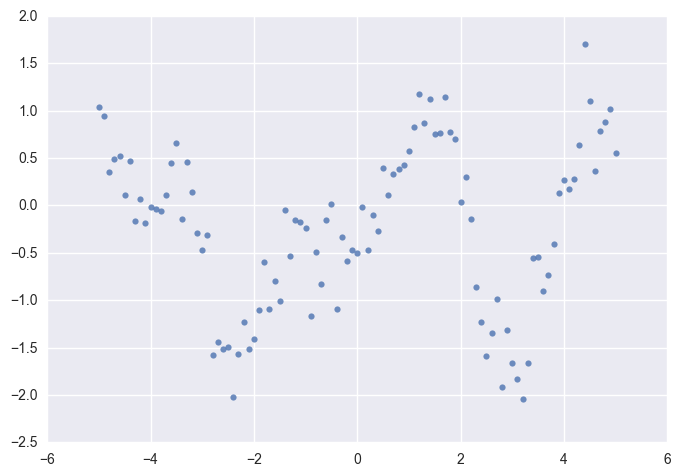

In [3]:
sns.regplot(x, y, fit_reg=False)

## scikit-learn

In [7]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, Matern, WhiteKernel

In [8]:
X = x.reshape(-1, 1)

In [9]:
kernel = (Matern(length_scale=1, nu=10) 
          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)))

In [10]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=10) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [11]:
gp.score(X, y)

0.8905423757159916

In [12]:
x_pred = np.linspace(-6, 6).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

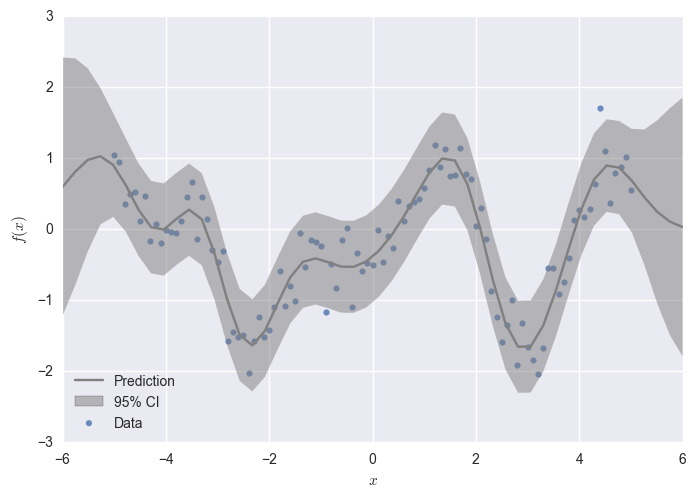

In [13]:
sns.regplot(x, y, fit_reg=False, label='Data')
plt.plot(x_pred, y_pred, color='grey', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='95% CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-6, 6)
plt.legend(loc='lower left');

## GPy

In [11]:
import GPy

In [12]:
kernel = GPy.kern.Matern32(1, variance=10, lengthscale=1.2)

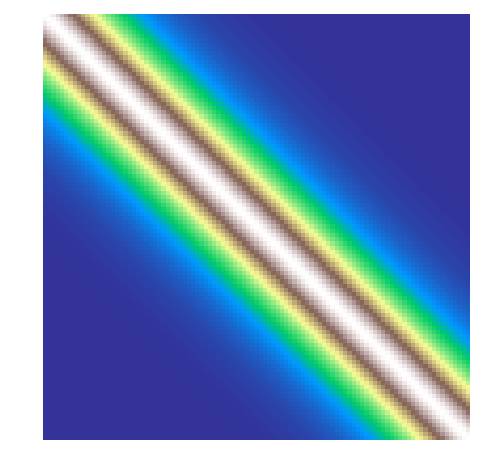

In [13]:
K_xx = kernel.K(X,X)
plt.imshow(np.asmatrix(K_xx), cmap='terrain', interpolation='nearest')
plt.axis('off');

In [14]:
Y = y.reshape(-1,1)

In [15]:
m = GPy.models.GPRegression(X=X, Y=Y, kernel=kernel)
m.optimize()

 /Users/fonnescj/anaconda3/envs/dev/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


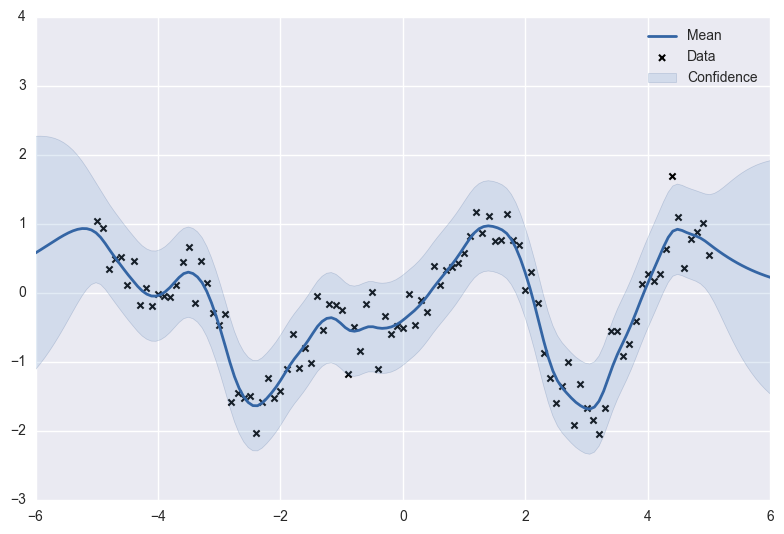

In [17]:
m.plot(xlim=(-6,6), ylim=(-3,4));

## GPflow

In [18]:
import GPflow

In [19]:
k = (GPflow.kernels.Matern32(1, variance=10, lengthscales=1.2) 
     + GPflow.kernels.White(1, variance=0.3))
m = GPflow.gpr.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01

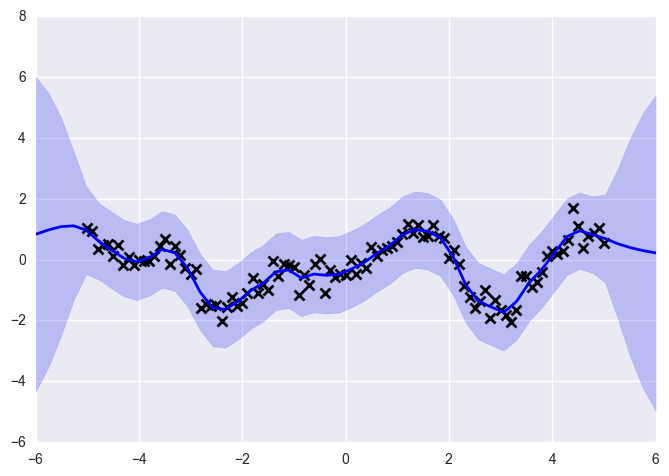

In [20]:
def plot(m):
    xx = np.linspace(-6, 6).reshape(-1,1)
    mean, var = m.predict_y(xx)
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-6, 6)
plot(m)

## Stan

In [12]:
import pystan

In [11]:
gp_model = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;
}
parameters {
  real<lower=0> eta_sq;
  real<lower=0> rho_sq;
  real<lower=0> sigma_sq;
}
model {
  matrix[N,N] Sigma;

  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      Sigma[i,j] <- eta_sq * exp(-rho_sq * pow(x[i] - x[j],2));
      Sigma[j,i] <- Sigma[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N)
    Sigma[k,k] <- eta_sq + sigma_sq; // + jitter

  eta_sq ~ cauchy(0,5);
  rho_sq ~ cauchy(0,5);
  sigma_sq ~ cauchy(0,5);

  y ~ multi_normal(mu,Sigma);
}
"""

In [14]:
gp_data = {'N': N, 'y': y, 'x': x}

fit = pystan.stan(model_code=gp_model, data=gp_data,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d0ec948d8a61ab687ea1e57e5fb3deb NOW.


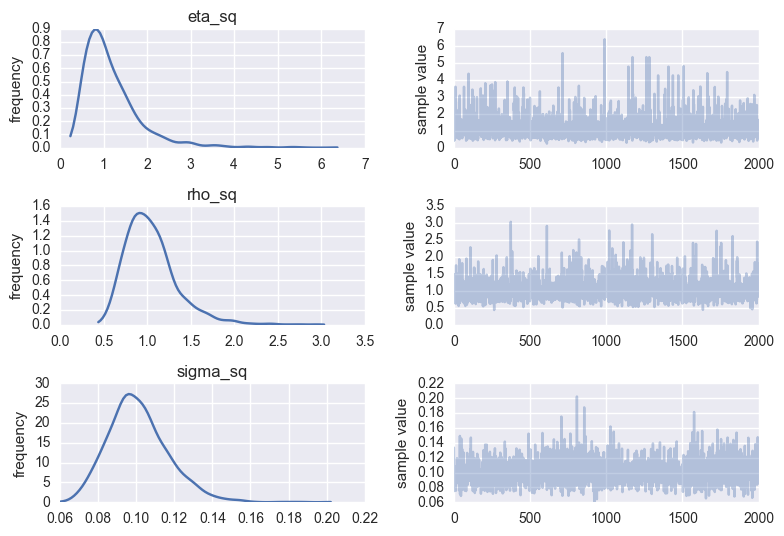

In [21]:
fit.traceplot(pars=['eta_sq', 'rho_sq', 'sigma_sq'])
plt.tight_layout()

## PyMC3

In [4]:
import pymc3 as pm
from scipy.spatial.distance import cdist
from theano.tensor.nlinalg import matrix_inverse
import theano.tensor as tt

In [14]:
with pm.Model() as gp_fit:
    
    μ = np.zeros(N)
    
    η_sq = pm.HalfCauchy('η_sq', 5)
    ρ_sq = pm.HalfCauchy('ρ_sq', 5)
    σ_sq = pm.HalfCauchy('σ_sq', 5)
    
    D = cdist(X, X, 'sqeuclidean')
    
    # Squared exponential
    Σ = tt.fill_diagonal(η_sq * tt.exp(-ρ_sq * D), η_sq + σ_sq)
    
    obs = pm.MvNormal('obs', μ, Σ, observed=y)

In [15]:
with gp_fit:
    
    # Prediction over grid
    xgrid = np.linspace(-6, 6).reshape(-1,1)
    D_pred = cdist(xgrid, xgrid, 'sqeuclidean')
    D_off_diag = cdist(xgrid, X, 'sqeuclidean')
    
    # Covariance matrices for prediction
    Σ_pred = η_sq * tt.exp(-ρ_sq * D_pred)
    Σ_off_diag = η_sq * tt.exp(-ρ_sq * D_off_diag)
    
    # Posterior mean
    μ_post = pm.Deterministic('μ_post', tt.dot(tt.dot(Σ_off_diag, matrix_inverse(Σ)), y))
    # Posterior covariance
    Σ_post = pm.Deterministic('Σ_post', Σ_pred - tt.dot(tt.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T))

In [26]:
with gp_fit:
    trace = pm.sample(2000, init=None)

Assigned NUTS to η_sq_log_
Assigned NUTS to ρ_sq_log_
Assigned NUTS to σ_sq_log_
100%|██████████| 2000/2000 [02:12<00:00, 24.35it/s]


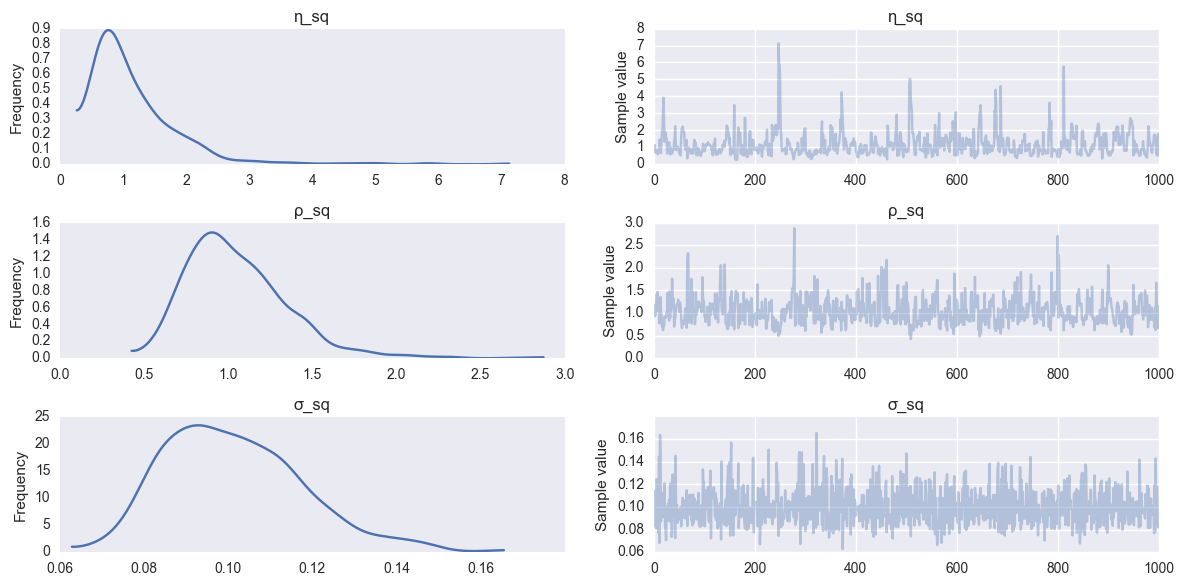

In [30]:
pm.traceplot(trace[-1000:], varnames=['η_sq', 'ρ_sq', 'σ_sq']);

In [28]:
y_pred = [np.random.multivariate_normal(m, S) for m, S in zip(trace['μ_post', -100:], 
                                                              trace['Σ_post', -100:])]

/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


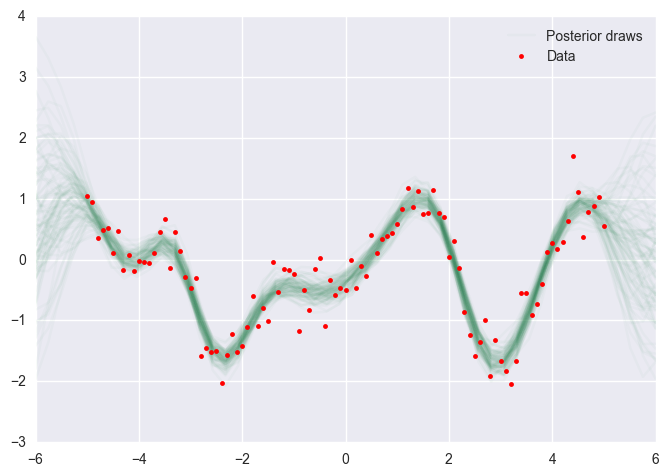

In [29]:
for i,yp in enumerate(y_pred):
    if not i:
        label = 'Posterior draws'
    else:
        label = None
    plt.plot(np.linspace(-6, 6), yp, color='SeaGreen', alpha=0.03, label=label);
plt.plot(x, y, 'r.', label='Data')
plt.ylim(-3, 4)
plt.legend();